Authors: dylan dorey, ethan harris, halin gailey, jake baartman

Trains a simple fully connected neural network (MLP) on MNIST
 - evaluates it on both MNIST and a class digits dataset
 - computes per class loss and confusion matrices
 - generates per group performance stats (loss and acc)

In [24]:
import time
import pathlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [25]:
ROOT = pathlib.Path().resolve()
DIGITS_DIR = ROOT / "digits"
MNIST_DIR = ROOT / "mnist_data"

print("Notebook directory:", ROOT)
print("Digits directory:", DIGITS_DIR)
print("MNIST path:", MNIST_DIR)

Notebook directory: /Users/halingailey/CSCI580
Digits directory: /Users/halingailey/CSCI580/digits
MNIST path: /Users/halingailey/CSCI580/mnist_data


Global config / device

In [26]:
# digits 0 - 9
NUM_CLASSES = 10

# use the GPU here if it is available, if not use CPU like usual
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)


Using device: cpu


Visualization helpers
- These functions are for plotting and presentaiton purposes only
-- confusion matrix with counts
-- per class loss table
-- per group accuracy and loss bar charts

In [27]:
# plot and save confusion matrix with numeric labels  
def show_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_yticks(range(NUM_CLASSES))
    ax.set_xticklabels(range(NUM_CLASSES))
    ax.set_yticklabels(range(NUM_CLASSES))

    # add the raw count text inside each cell
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            ax.text(
                j, i,
                str(value),
                ha="center",
                va="center",
                color="white" if value > thresh else "black",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [28]:
# plot a table for per class average loss
# - row 1: digits 0 - 1
# - row 2: per class loss 
def show_loss_table(class_avg_loss):

    class_avg_loss = np.asarray(class_avg_loss)

    # visualization formatting: no leading 0 for decimal values < 1 and only 2 sf
    loss_row = [f"{loss:.2f}"[1:] if loss < 1 else f"{loss:.2f}" for loss in class_avg_loss]

    digit_row = [str(d) for d in range(NUM_CLASSES)]
    table_data = [digit_row, loss_row]

    fig, ax = plt.subplots(figsize=(6, 1.4))
    ax.axis("off")

    table = ax.table(
        cellText=table_data,
        loc="center",
        cellLoc="center",
    )

    # visualization formatting: parameters for compactness
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(0.8, 0.6)

    # header row: light blue
    # data row: white and small padding
    for (row, col), cell in table.get_celld().items():
        cell.PAD = 0.05
        if row == 0:
            cell.set_facecolor("#dbe9ff")
            cell.set_text_props(weight="bold")
        else:
            cell.set_facecolor("white")

        cell.set_height(0.15)

    plt.tight_layout(pad=0.1)
    plt.show()
    plt.close(fig)

In [29]:
# plot per gorup accuracy and loss as side by side bar chart
# blue bars: accuracy %
# orange bars: loss

def plot_group_results(group_ids, group_losses, group_accs):
    group_ids = list(group_ids)
    group_losses = list(group_losses)
    group_accs = list(group_accs)

    x = np.arange(len(group_ids))
    width = 0.25

    fig, ax1 = plt.subplots(figsize=(7, 6))

    # left axis = accuracy
    acc_bars = ax1.bar(
        x - width / 2,
        [a * 100.0 for a in group_accs],
        width,
        label="Accuracy (%)",
        color="tab:blue",
        edgecolor="black"
    )
    ax1.set_ylabel("Accuracy (%)", color="tab:blue")
    ax1.set_ylim(0, 100)

    # right axis = loss
    ax2 = ax1.twinx()
    loss_bars = ax2.bar(
        x + width / 2,
        group_losses,
        width,
        label="Loss",
        color="tab:orange",
        edgecolor="black"
    )
    ax2.set_ylabel("Loss", color="tab:orange")

    # x-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels([str(g) for g in group_ids], fontsize=10)
    ax1.set_xlabel("Group")
    ax1.set_title("Per Group Accuracy and Loss", fontsize=14)

    # Legend - handles from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels  = labels1  + labels2

    fig.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.08),
        ncol=2,
        frameon=True,
        fontsize=12
    )

    fig.tight_layout()
    plt.show()
    plt.close(fig)



Data loading helpers + dataset wrappers
- wrap the png files into np arrays and PyTorch datasets

In [30]:
# loads all class digits from the directory into np arrays
# - expects filenames of the form: digit-group-member.png
# - only the first field is used as a label here (the digit)
# - filters out data based on: too faint, low contrast, too few bright pixels
def project_data_loader(digits_dir="../digits"):

    digits_path = pathlib.Path(digits_dir)
    image_list = []
    label_list = []

    for png_path in sorted(digits_path.glob("*.png")):

        # filenames follow as convention: digit-group-member.png
        # - we just need the digit here (first field)
        fname = png_path.stem
        parts = fname.split("-")
        if len(parts) < 1:
            continue
        try:
            label = int(parts[0])
        except ValueError:
            continue

        # load and normalize to 28x28 grayscale to match MNIST format
        img = Image.open(png_path).convert("L")
        # resize to 28x28 to match MNIST dimensions and model input requirements
        img = img.resize((28, 28))

        arr = np.array(img, dtype=np.float32)
        
        # quality filtering heuristics:
        # - max_pix < 70: the digit is too faint to be used
        # - foregroung_pixels: ensures the image isnt blank or just noise
        # - contrast < 30: aoids extremely low contrast digits that confuse the model
        max_pix = arr.max()
        foreground_pixels = (arr > 60).sum()
        contrast = arr.max() - arr.min()

        # these threshold prevent extremely low quality or blank digits
        # from corrupting the test results
        if max_pix < 70:
            print(f"Skipping {png_path.name}: too faint (max={max_pix})")
            continue

        if foreground_pixels < 10:
            print(f"Skipping {png_path.name}: almost blank ({foreground_pixels} bright pixels)")
            continue

        if contrast < 30:
            print(f"Skipping {png_path.name}: low contrast (range={contrast})")
            continue

        image_list.append(arr)
        label_list.append(label)
        
    # stack into (N, 28, 28)
    # if no images, return empty np array with same shape
    images = np.stack(image_list, axis=0) if image_list else np.empty((0, 28, 28), dtype=np.float32)
    labels = np.array(label_list, dtype=np.int64)
    return images, labels

In [31]:
# load digits and group them by groupID
# - expected filenames: digit-group-member.png
# returns dict[group_id] = (images_np, labels_np)
# applies the same heuristic filters as project_data_loader() above
def load_grouped_digits(digits_dir="../digits"):

    digits_path = Path(digits_dir)
    group_images = {}
    group_labels = {}

    for png_path in sorted(digits_path.glob("*.png")):

        # filenames follow as convention: digit-group-member.png
        # - we just need the digit here (first field)
        fname = png_path.stem
        parts = fname.split("-")
        if len(parts) < 2:
            continue
        try:
            label = int(parts[0])
            group = int(parts[1])
        except ValueError:
            continue

        # load and normalize to 28x28 grayscale to match MNIST format
        img = Image.open(png_path).convert("L")
        # resize to 28x28 to match MNIST dimensions and model input requirements
        img = img.resize((28, 28))

        arr = np.array(img, dtype=np.float32)
        
        # quality filtering heuristics:
        # - max_pix < 70: the digit is too faint to be used
        # - foregroung_pixels: ensures the image isnt blank or just noise
        # - contrast < 30: aoids extremely low contrast digits that confuse the model
        max_pix = arr.max()
        foreground_pixels = (arr > 60).sum()
        contrast = arr.max() - arr.min()

        # these threshold prevent extremely low quality or blank digits
        # from corrupting the test results
        if max_pix < 70:
            continue
        if foreground_pixels < 20:
            continue
        if contrast < 30:
            continue

        group_images.setdefault(group, []).append(arr)
        group_labels.setdefault(group, []).append(label)
        
    grouped = {}
    for g in group_images:
        images = np.stack(group_images[g], axis=0).astype(np.float32)
        labels = np.array(group_labels[g], dtype=np.int64)
        grouped[g] = (images, labels)

    return grouped

In [32]:
# wraps the class digits form project_data_loader() so we cna use them
# in PyTorch dataloader with the same trasnforms as MNIST
class project_digits_dataset(torch.utils.data.Dataset):

    def __init__(self, digits_dir="../digits", transform=None):
        self.images_np, self.labels_np = project_data_loader(digits_dir)
        self.transform = transform

    def __len__(self):
        return len(self.labels_np)

    def __getitem__(self, idx):
        img_arr = self.images_np[idx]
        label = int(self.labels_np[idx])

        # convert np array back to PIL bc torchvision transforms operate on PIL images
        img = Image.fromarray(img_arr.astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [33]:
# dataset wrapper for pre loaded np image arrays and labels 
# used for per group evaluation
class numpy_digits_dataset(torch.utils.data.Dataset):

    def __init__(self, images_np, labels_np, transform=None):
        self.images_np = images_np
        self.labels_np = labels_np
        self.transform = transform

    def __len__(self):
        return len(self.labels_np)

    def __getitem__(self, idx):
        img_arr = self.images_np[idx]
        label = int(self.labels_np[idx])

        # convert np array back to PIL bc torchvision transforms operate on PIL images
        img = Image.fromarray(img_arr.astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        return img, label

Model + evaluation + training helpers

In [34]:
# fully connected MLP for 28x28 digits
# architecture:
# - input: 784 dim flattened image
# - hidden layers: 512 -> 256 -> 128 with ReLU + dropout
# - output: 10 logits (1 for each digit class)
class MLP(nn.Module):

    # layer sizes chosen to balane capacity and training speed
    # tried 256 -> 128 -> 64 and it didnt perform as well
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, NUM_CLASSES)
        # dropout added to reduce overfitting
        # - important for training on MNIST
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten the 28x28 image into 784 legnth vector for fully connected layers
        # - flatten from (batch, 1, 28, 28) -> (batch, 784)
        x = x.view(x.size(0), -1)
        # dropout adds regularization and reduces overfitting on MNIST
        # - important bc the model is large for a simple dataset
        # - apply dropout after each hidden layer to improve the generalization
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [35]:
# evaluate the model on a given DataLoader
# returns:
# - avg_loss: mean cross entropy over all samples
# - accuracy: fraction of correctly classified samples
# - cm: confusion matrix
# - class_avg_loss: per class average loss
def evaluate(model, dataloader, device, criterion, compute_confusion=False, num_classes=NUM_CLASSES):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    cm = None
    if compute_confusion:
        cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # for per-class loss analysis
    class_loss_sum = np.zeros(num_classes, dtype=np.float64)
    class_loss_count = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item() * images.size(0)

            # predicted class indices
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # update confusion matrix if requested
            if compute_confusion:
                true_np = labels.cpu().numpy()
                pred_np = preds.cpu().numpy()
                for t, p in zip(true_np, pred_np):
                    cm[t, p] += 1

            # per-sample loss to accumulate per-class averages
            per_item_loss = nn.functional.cross_entropy(
                logits, labels, reduction="none"
            ).cpu().numpy()

            for lbl, loss_val in zip(labels.cpu().numpy(), per_item_loss):
                class_loss_sum[lbl] += loss_val
                class_loss_count[lbl] += 1

    if total == 0:
        if compute_confusion:
            # return empty-ish things but still 4 values
            class_avg_loss = class_loss_sum / np.maximum(class_loss_count, 1)
            return float("nan"), float("nan"), cm, class_avg_loss
        else:
            return float("nan"), float("nan")

    avg_loss = running_loss / total
    accuracy = correct / total
    class_avg_loss = class_loss_sum / np.maximum(class_loss_count, 1)

    if compute_confusion:
        return avg_loss, accuracy, cm, class_avg_loss
    else:
        return avg_loss, accuracy

In [37]:
# supervised training loop on MNIST
# - tracks and returns training loss per epoch for plotting later
# - uses Adam + cross entropy on augmented MNIST data

def train_with_early_stopping(model, trainloader, valloader, device, 
                              criterion, optimizer, epochs=20, patience=3):
    
    best_val_loss = float("inf")
    best_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        running_train_loss = 0.0
        total_train = 0

        for images, labels in trainloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            batch_size_curr = images.size(0)
            running_train_loss += loss.item() * batch_size_curr
            total_train += batch_size_curr

        epoch_train_loss = running_train_loss / total_train
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        total_val = 0

        with torch.no_grad():
            for images, labels in valloader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                logits = model(images)
                val_loss = criterion(logits, labels)

                batch_size_curr = images.size(0)
                running_val_loss += val_loss.item() * batch_size_curr
                total_val += batch_size_curr

        epoch_val_loss = running_val_loss / total_val
        val_losses.append(epoch_val_loss)

        print(
            f"Epoch {epoch}/{epochs} "
            f"- Train loss: {epoch_train_loss:.4f} "
            f"- Val loss: {epoch_val_loss:.4f}"
        )

        # Early stopping 
        if epoch_val_loss < best_val_loss - 1e-4:
            best_val_loss = epoch_val_loss
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(
                    f"Early stopping triggered at epoch {epoch} "
                    f"(no val-loss improvement in {patience} epochs)."
                )
                break

    # Load best weights before returning
    model.load_state_dict(best_state)

    print(f"Best validation loss: {best_val_loss:.4f}")
    return train_losses, val_losses


In [38]:
# evaluate the trianed model separately for each group (second number in filename)
# - helps us identify whether certain groups draw differently
# - useful for disgnosing bias or harder writing style
# - for each group:
# -- build a small dataset from that groups images
# -- run evaluate() to get loss + accuracy
# - returns: group_ids, group_losses, group_accs
def evaluate_by_group(model, device, criterion, test_transform, digits_dir="../digits"):

    # load digits grouped by the second number in filename
    # - we cna see if certain groups draw digits differently
    grouped_digits = load_grouped_digits(digits_dir)

    group_ids = sorted(grouped_digits.keys())
    group_losses = []
    group_accs = []

    for g in group_ids:
        images_np, labels_np = grouped_digits[g]
        if len(labels_np) == 0:
            continue

        group_dataset = numpy_digits_dataset(images_np, labels_np, transform=test_transform)
        group_loader = torch.utils.data.DataLoader(
            group_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )

        g_loss, g_acc = evaluate(
            model, group_loader, device, criterion, compute_confusion=False
        )

        # store group accuracy and loss to use in plot later
        group_losses.append(g_loss)
        group_accs.append(g_acc)
        print(f"Group {g}: loss = {g_loss:.4f}, acc = {100.0 * g_acc:.2f}% (N={len(group_dataset)})")

    return group_ids, group_losses, group_accs

Main script
- define transforms and load MNIST train/test sets
- train MLP on MNIST with light data augmentation
- evaluate on MNIST test set (loss and accuracy)
- evaluate on class digits dataset as a whole (loss and accuracy)
- get the confusion matrix and per class average loss for each test
- evaluate per group and plot group performance (loss and acc)

In [39]:
batch_size = 128

# data augmentation for trianing
# - small random affine distortion (rotation/translation/scale/sher)
# - helps simulate natural handwriting variation and improves robustness
train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=5,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=5
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# test transform: just tensor + normalization
# - no augmentation so evaulaiton is fair and consistent
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST set for train/val
full_trainset = datasets.MNIST(
    root=str(MNIST_DIR),
    train=True,
    download=True,
    transform=train_transform
)

# 85% train, 15% validation
val_frac = 0.15
n_full = len(full_trainset)
n_val = int(val_frac * n_full)
n_train = n_full - n_val

# MNIST set for train
train_dataset, val_dataset = random_split(
    full_trainset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

# MNIST dataloader for train set
trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

#MNIST dataloader for val set
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# MNIST test set / dataloader
testset = datasets.MNIST(
    root=str(MNIST_DIR),
    train=False,
    download=True,
    transform=test_transform
)
# MNIST is only used for training and baseline evaluation
testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [40]:
# model, loss, optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [41]:
# train model on MNIST
epochs = 20
patience = 3

train_losses, val_losses = train_with_early_stopping(
    model,
    trainloader,
    valloader,
    device,
    criterion,
    optimizer,
    epochs=epochs,
    patience=patience
)

Epoch 1/20 - Train loss: 1.0051 - Val loss: 0.4561
Epoch 2/20 - Train loss: 0.4884 - Val loss: 0.3607
Epoch 3/20 - Train loss: 0.3861 - Val loss: 0.2628
Epoch 4/20 - Train loss: 0.3382 - Val loss: 0.2461
Epoch 5/20 - Train loss: 0.3143 - Val loss: 0.2134
Epoch 6/20 - Train loss: 0.2875 - Val loss: 0.2175
Epoch 7/20 - Train loss: 0.2782 - Val loss: 0.1950
Epoch 8/20 - Train loss: 0.2567 - Val loss: 0.1978
Epoch 9/20 - Train loss: 0.2500 - Val loss: 0.1729
Epoch 10/20 - Train loss: 0.2384 - Val loss: 0.1724
Epoch 11/20 - Train loss: 0.2353 - Val loss: 0.1459
Epoch 12/20 - Train loss: 0.2252 - Val loss: 0.1475
Epoch 13/20 - Train loss: 0.2240 - Val loss: 0.1653
Epoch 14/20 - Train loss: 0.2128 - Val loss: 0.1355
Epoch 15/20 - Train loss: 0.2131 - Val loss: 0.1503
Epoch 16/20 - Train loss: 0.2106 - Val loss: 0.1450
Epoch 17/20 - Train loss: 0.2033 - Val loss: 0.1307
Epoch 18/20 - Train loss: 0.2021 - Val loss: 0.1405
Epoch 19/20 - Train loss: 0.2034 - Val loss: 0.1376
Epoch 20/20 - Train l

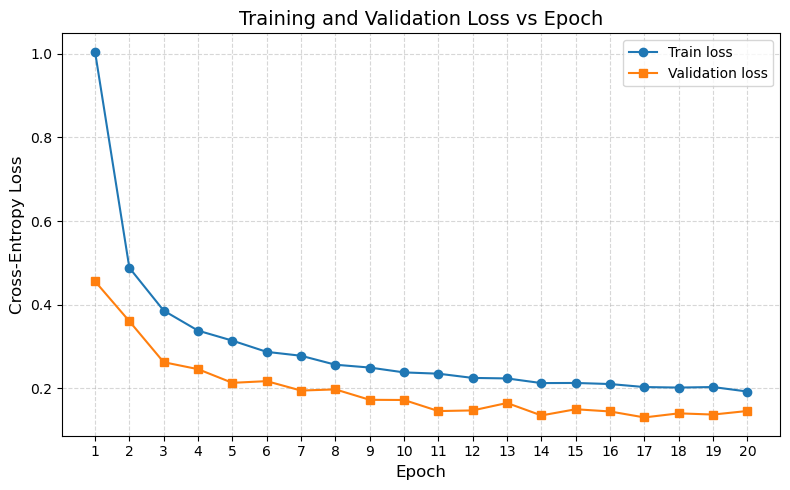

In [42]:
# plot the above training results
plt.figure(figsize=(8, 5))
epochs_ran = range(1, len(train_losses) + 1)

plt.plot(epochs_ran, train_losses, marker="o", label="Train loss")
plt.plot(epochs_ran, val_losses,   marker="s", label="Validation loss")

plt.title("Training and Validation Loss vs Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(epochs_ran)
plt.legend()
plt.tight_layout()
plt.show()

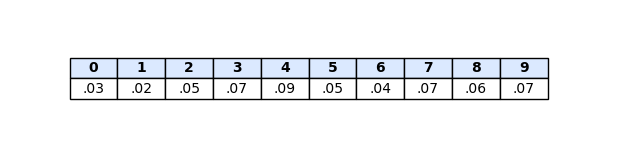

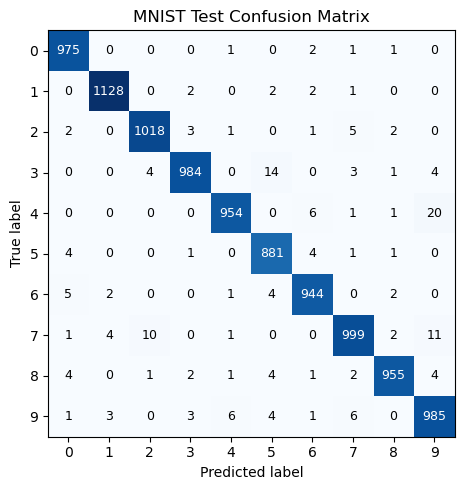

MNIST Test loss: 0.0539, accuracy: 98.23%


In [43]:
# Evaluate on MNIST test set
test_loss, test_acc, test_cm, mnist_avg_loss = evaluate(
    model, testloader, device, criterion, compute_confusion=True
)

show_loss_table(mnist_avg_loss)
show_confusion_matrix(test_cm, "MNIST Test Confusion Matrix")
print(f"MNIST Test loss: {test_loss:.4f}, accuracy: {100 * test_acc:.2f}%")

Skipping 1-1-3.png: too faint (max=44.0)
Skipping 2-1-3.png: too faint (max=55.0)
Skipping 3-1-3.png: too faint (max=38.0)
Skipping 4-1-3.png: too faint (max=42.0)
Skipping 5-1-3.png: too faint (max=37.0)
Skipping 6-1-3.png: too faint (max=35.0)
Skipping 7-1-3.png: too faint (max=34.0)
Skipping 8-1-3.png: too faint (max=59.0)
Skipping 9-1-3.png: almost blank (2 bright pixels)


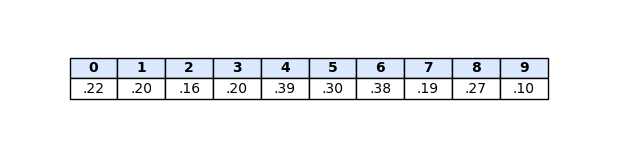

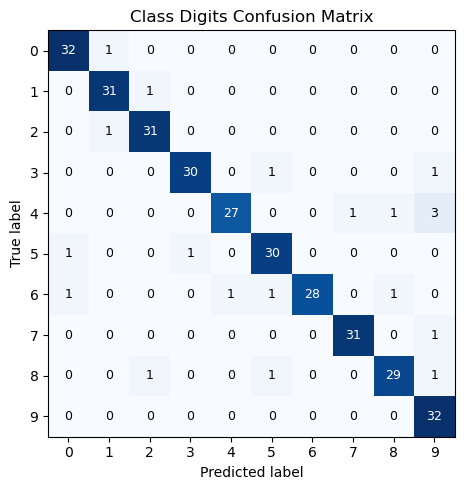


Class handwritten digits - loss: 0.2401, accuracy: 93.77%


In [45]:
# Evaluate on all class digits

project_dataset = project_digits_dataset(DIGITS_DIR, transform=test_transform)

project_loader = torch.utils.data.DataLoader(
    project_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

proj_loss, proj_acc, proj_cm, proj_avg_loss = evaluate(
    model, project_loader, device, criterion, compute_confusion=True
)

show_loss_table(proj_avg_loss)
show_confusion_matrix(proj_cm, "Class Digits Confusion Matrix")
print(f"\nClass handwritten digits - loss: {proj_loss:.4f}, accuracy: {100 * proj_acc:.2f}%")

Group 1: loss = 0.7281, acc = 80.65% (N=31)
Group 2: loss = 0.0794, acc = 100.00% (N=30)
Group 3: loss = 0.1338, acc = 95.00% (N=40)
Group 4: loss = 0.0748, acc = 97.50% (N=40)
Group 5: loss = 0.0102, acc = 100.00% (N=40)
Group 6: loss = 0.0201, acc = 100.00% (N=40)
Group 7: loss = 0.8564, acc = 75.00% (N=20)
Group 8: loss = 0.5933, acc = 80.00% (N=30)
Group 9: loss = 0.1906, acc = 100.00% (N=10)
Group 10: loss = 0.1468, acc = 100.00% (N=39)


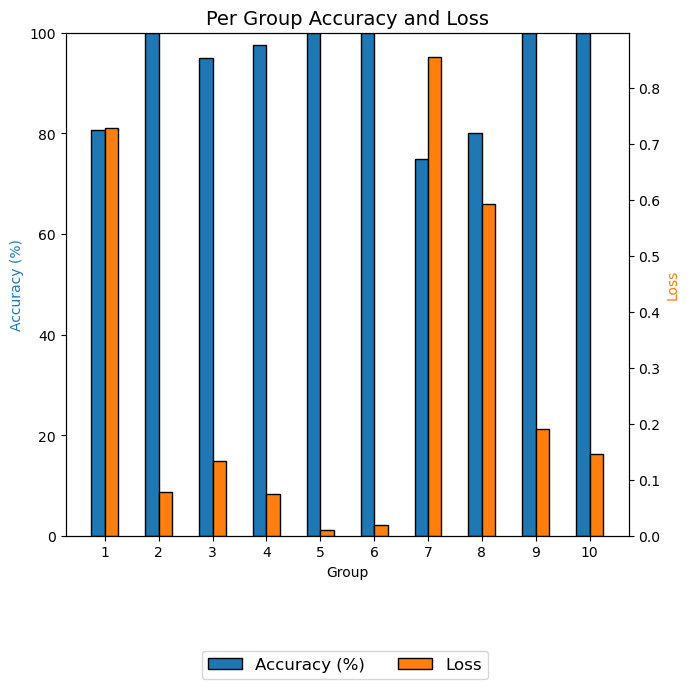

In [46]:
# Evaluate per group class digits
# - analyze performance differences due to style varaints

group_ids, group_losses, group_accs = evaluate_by_group(
    model, device, criterion, test_transform, digits_dir=DIGITS_DIR
)
    
plot_group_results(
    group_ids,
    group_losses,
    group_accs
)